# Projet phylogénétique
Marine Djaffardjy (marine.djaffardjy@u-psud.fr)- Théophile Sanchez - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

In [1]:
"""
Affiche joliement les numpy array 
"""
!pip install numpy-html
%reload_ext numpy_html

Defaulting to user installation because normal site-packages is not writeable


------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [2]:
import pandas as pd

"""
    @Function : read_fasta
    @Parameters : name_file(.fasta)
    @Return : dictionnary{name_seq1:seq1 , ... , name_seq2:seq2}
"""
def read_fasta(name_file):
    dic = {} #déclaration du dictionnaire qui va stocker les données lues
    doc = open(name_file,"r") #ouverture du fichier .fasta en lecture seulement
    for line in doc:
        if line.startswith(">"):
            nameSeq = line[1:].split("\n")[0].replace("(","").replace(")","") #nom de la séquence
            dic[nameSeq] = "" #on l'ajoute au dictionnaire comme clé avec initialement une valeur vide
        else:
            dic[nameSeq] += line.strip() #ajout au dictionnaire de la valeur correspondante à la clé
    return dic

                    
sequences = read_fasta("cat_dna.fasta")
pd.DataFrame(sequences.items(),columns=["Name","Sequence"])  #ici on utilise panda pour afficher joliement le dictionnaire

,Name,Sequence
0,Sabertooth DNA Smilodon,CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCAT...
1,Homotherium DNA,CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCT...
2,American Cat DNA Miracinonyx,CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCAT...
3,Spotted Hyena DNA,CTCATTAAAATTATCAACAAATCATTCATTGACCTCCCCACCCCAT...
4,Striped Hyena DNA,CTCATTAAAATTGTCAACGAATCATTCATCGATCTCCCCACCCCAT...
5,Chinese Desert cat DNA,CTTATTAAAATCATCAACCATTCATTCATTGACCTACCCACCCCAT...
6,African wild cat DNA,CTTATCAAAATTATTAATCACTCATTCATCGATCTACCCGCCCCAT...
7,Felis Cat A DNA,CTTACCAAAATTATTAATCACTCATTCATCGACCTACCTGCCCCAT...
8,Wild Cat DNA,CTTATCAAAATTATTAATCACTCATTCATCGACCTACCCGCCCCAT...
9,Cheetah DNA,CTTATCAAAATCGTTAATCACTCATTCATCGATTTACCCACCCCAC...


------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [4]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [5]:
"""
    @Function : score_alignment
    @Parameters : 
        - (string)seq1 : une séquence
        - (string)seq2 : une autre séquence
        - (SimilarityMatrix)similarity_matrix : matrice de similarité
        - (int)nb : nombre d'alignements (maximum la longueur de la plus longue sequence)
    @Return : (numpy_array)res : score de l'alignement a_1,...,a_nb
"""
def score_alignment(seq1,seq2,similarity_matrix,nb):
    #variables
    res = [0] * nb #on initialise un numpy array avec des zeros en fonction du nombre de scores voulus 
    max12 =  max(len(seq1),len(seq2)) #on stocke la longueur maximale entre les deux séquences données
    #si celle-ci est inférieure au maximum alors on va aligner les deux séquences sinon on renvoit un message d'erreur de la part de l'utilisateur
    if nb <= max12:
        seq1_format = seq1 #stockage temporaire de seq1 qu'on va modifier pour l'aligner
        seq2_format = seq2 #stockage temporaire de seq1 qu'on va modifier pour l'aligner
        """
            Si la premiere sequence est plus courte que la deuxieme sequence :
                - on ajoute un gap au debut de la premiere sequence 
                - on ajoute autant de gap à la fin de la premire sequence qu'il lui en manquent 
                
            Si la premiere sequence est plus longue que la deuxieme sequence : 
                - on remplace le premier caractere de la premiere sequence par un gap 
                - on ajoute autant de gap à la fin de la deuxieme sequence qu'il lui en manquent
                
            Si les deux sequences sont egales :
                - on remplace seulement le premiere caractere de la premiere sequence par un gap 
        """
        if len(seq1) < len(seq2):
            seq1_format = "-" + seq1
            for i in range(len(seq2)-len(seq1)-1):
                seq1_format = seq1_format + "-"
        elif len(seq1) > len(seq2):
            seq1_format = "-" + seq1[1:]
            for i in range(len(seq1)-len(seq2)):
                seq2_format = seq2_format + "-"
        else:
            seq1_format = "-" + seq1[1:]

        list_seq = [] #liste qui contiendra la premiere sequence avec un gap au caractere + 1 pour chaque iteration
        list_seq.append(seq1_format) #on ajoute la premiere 
        for i in range(nb-1):
            value = seq1[0:i+1] + "-" + seq1[i+1:] #on place le gap dans la premiere sequence
            list_seq.append(value) #on l'ajoute à la liste

        """
            On itère sur chacune des séquences qu'on vient de créer à partir de la séquence une pour lesquelles:
                - On calcule le score de l'alignement avec la séquence deux 
                - On ajoute le résultat dans res 
        """
        for i in range(len(list_seq)):
            seq1_f = list_seq[i]
            for j in range(len(seq1_format)):
                res[i] = res[i] + similarity_matrix.score(seq1_f[j],seq2_format[j]) 
    else:
        print("Error : nb", nb, " > ", max12)

    return res

nb = 9
score = score_alignment("ACTCCTGA","ATCTCGTGA",similarity_matrix,nb)
score

[35.0, 49.0, 39.0, 28.0, 18.0, 30.0, 22.0, 13.0, 0.0]

------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [10]:
import pandas as pd

"""
    @Function : needlman_wunsch
    @Parameters : 
        - [string] seq1 : une séquence
        - [string] seq2 : une autre séquence
        - [SimilarityMatrix] similarity_matrix : matrice de similarité
    @Return : 
        - [0] : matrice de score
        - [1] : matrice de traceback 
        - [2] : matrice d'alignement
        - [3] : seq1 alignée
        - [4] : seq2 alignée
"""
def needlman_wunsch(seq1,seq2,similarity_matrix):
    #variables
    M = np.zeros([len(seq1)+1,len(seq2)+1]) #initialisation de la matrice de score 
    T = np.empty([len(seq1)+1,len(seq2)+1],dtype=str) #initialisation de la matrice de traceback
    T2 = np.empty([len(seq1)+1,len(seq2)+1],dtype=str) #initialisation de la matrice de l'alignement
    res1 = "" #initialisation de la sequence1 alignée qu'on va renvoyer
    res2 = "" #initialisation de la sequence2 alignée qu'on va renvoyer
    i = len(seq1) #longueur de la sequence1
    j = len(seq2) #longueur de la sequence2
    
    #initialisation premiere ligne-colonne de la matrice traceback
    T[0][0] = "o"
    
    #initialisation des valeurs des colonnes de la premiere ligne pour la matrice de score et de traceback
    for j in range(1,len(seq2)+1):
        M[0][j] = M[0][j-1] + similarity_matrix.score("-",seq2[j-1])
        T[0][j] = "l"
        
   #initialisation des valeurs des lignes de la premiere colonne pour la matrice de score et de traceback  
    for i in range(1,len(seq1)+1):
        #print(i)
        M[i][0] = M[i-1][0] + similarity_matrix.score("-",seq1[i-1])
        T[i][0] = "u"
        
    """
        1) On remplit la matrice de score selon la formule 𝑀𝑖𝑗=max(𝑀𝑖−1𝑗−1+𝑠(𝐴𝑖,𝐵𝑗),𝑀𝑖𝑗−1+𝑠(𝐴𝑖,𝑔𝑎𝑝),𝑀𝑖−1𝑗+𝑠(𝐵𝑗,𝑔𝑎𝑝))
        2) On remplit la matrice de traceback par rapport à la matrice de score telle que : 
            -'d' (diagonal) si 𝑀𝑖𝑗 a été calculé en utilisant la diagonale 𝑀𝑖−1𝑗−1 (max1)
            -'l' (left) si 𝑀𝑖𝑗 a été calculé en utilisant la case de gauche 𝑀𝑖𝑗−1 (max2)
            -'u' (up) si 𝑀𝑖𝑗 a été calculé en utilisant la case du haut 𝑀𝑖−1𝑗 (max3)
    """
    for i in range(1,len(seq1)+1):
        for j in range(1,len(seq2)+1):
            max1 = M[i-1][j-1]+ similarity_matrix.score(seq1[i-1],seq2[j-1])
            max2 = M[i][j-1] + similarity_matrix.score(seq1[i-1],"-")
            max3 = M[i-1][j] + similarity_matrix.score(seq2[j-1],"-")
            M[i,j] = max(max1,max2,max3)
            if M[i,j] == max1:
                T[i,j] = "d"
            elif M[i,j] == max2:
                T[i,j] = "l"
            elif M[i,j] == max3:
                T[i,j] = "u"

    #initialisation premiere ligne-colonne de la matrice d'alignement
    T2[0][0] = "o"
    """
        On part de la derniere ligne-colonne jusqu'à tomber sur la valeur 'o'
        
            - Si la valeur est "d" alors on se déplace dans la diagonale 
                    [1] On ajoute a res1 le caractere de seq1 correspondant a l'indice de la case.
                    [2] On ajoute a res2 le caractere de seq2 correspondant a l'indice de la case.

            - Si la valeur est "l" alors on se déplace vers la gauche
                    [1] On ajoute a res1 un gap.
                    [2] On ajoute a res2 le caractere correspondant a l'indice de la case. 
                    
            - Si la valeur est "u" alors on se déplace vers la droite (si on est à la première itération - auquel cas diagionale) 
                    [1] On ajoute a res1 le caractere correspondant a l'indice de la case.
                    [2] On ajoute a res2 le gap.
        Et on oublie pas de remplir la matrice d'alignement par la même occasion.
    """
    while (T[i][j] != "o"):
        #print(i)
        #print(j)
        if T[i][j] == "d":
            res1 = res1 + seq1[i-1]
            res2 = res2 + seq2[j-1]
            T2[i][j] = "d"
            i = i-1 #pour aller dans la diagonale
            j = j-1 #pour aller dans la diagonale
        elif T[i][j] == "l":
            res1 = res1 + "-"
            res2 = res2 + seq2[j-1]
            T2[i][j] = "l"
            j = j - 1 #pour aller a gauche
        elif T[i][j] == "u" and j != len(seq2):
            res1 = res1 + seq1[i-1]
            res2 = res2 + "-"
            T2[i][j] = "u"
            j = j + 1 #pour aller a droite 
        elif T[i][j] == "u" and j == len(seq2):
            res1 = res1 + "-"
            res2 = res2 + "-"
            T2[i][j] = "u"
            j = j-1
            i = i-1
            

        
    #Pour finir, on oublie pas de retourner les séquences qu'on vient de créer (puisqu'on est parti de la fin pour les créer)
    return M,T,T2,res1[::-1],res2[::-1]


result = needlman_wunsch("A-CTCCTGA","ATCTCGTGA",similarity_matrix)
print("\n Matrice de score : ")
result[0]


 Matrice de score : 


0.,-5.,-10.,-15.,-20.,-25.,-30.,-35.,-40.,-45.
-5.,10.,5.,0.,-5.,-10.,-15.,-20.,-25.,-30.
-5.,5.,5.,5.,5.,5.,5.,5.,5.,5.
-10.,0.,2.,12.,7.,12.,7.,2.,0.,4.
-15.,-5.,8.,7.,20.,15.,12.,15.,10.,5.
-20.,-10.,3.,15.,15.,27.,22.,17.,12.,9.
-25.,-15.,-2.,10.,12.,22.,22.,19.,14.,11.
-30.,-20.,-7.,5.,18.,17.,22.,30.,25.,20.
-35.,-25.,-12.,0.,13.,13.,26.,25.,39.,34.
-40.,-25.,-17.,-5.,8.,12.,21.,22.,34.,49.


In [11]:
print("\n Matrice de traceback : ")
result[1]


 Matrice de traceback : 


'o','l','l','l','l','l','l','l','l','l'
'u','d','l','l','l','l','l','l','l','d'
'u','u','d','l','l','l','l','l','l','l'
'u','u','d','d','l','d','l','d','d','d'
'u','u','d','u','d','l','d','d','l','l'
'u','u','u','d','u','d','l','l','l','d'
'u','u','u','d','d','d','d','d','l','d'
'u','u','d','u','d','u','d','d','l','l'
'u','u','u','u','u','d','d','u','d','l'
'u','d','u','u','u','d','u','d','u','d'


In [12]:
print("\n Matrice de l'alignement :")
result[2]


 Matrice de l'alignement :


'o','','','','','','','','',''
'','d','','','','','','','',''
'','','d','','','','','','',''
'','','','d','','','','','',''
'','','','','d','','','','',''
'','','','','','d','','','',''
'','','','','','','d','','',''
'','','','','','','','d','',''
'','','','','','','','','d',''
'','','','','','','','','','d'


In [13]:
print("\nMeilleur alignement global entre les deux séquences : \n")
np.array([result[3],result[4]])


Meilleur alignement global entre les deux séquences : 



'A-CTCCTGA'
'ATCTCGTGA'


----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [14]:
"""
    @Function : p_distance
    @Parameters : 
        - [dictionnary] dictionnary: dictionnaire obtenu à partir d'un fichier (.fasta)
        - [SimilarityMatrix] similarity_matrix : matrice de similarité
    @Return : une matrice de distance du type string 
"""
def p_distance(dictionnary,similarity_matrix):
    values = list(dictionnary.values()) #liste avec les séquences
    keys = list(dictionnary.keys()) #liste avec le nom des séquences
    size = len(values) #taille du dictionnaire
    dist = np.zeros([size+1,size+1],dtype='<U100000') #initialisation de la matrice de distance (qui contiendra aussi le  noms de séquences)
    length = len(dist) #taille de la matrice 
    dist[0][0] = 0 #valeur de la premiere ligne-colonne
    dist[0,1:] = keys #initialisation de la premiere ligne avec le nom des séquences
    dist[1:,0] = keys #initialisation de la premiere colonne avec le nom des séquences
    #print(length)
    
    #on calcule le nombre de substitions entre deux séquences pour obtenir la distance (seulement pour la diagonale car matrice symétrique)
    for j in range(1,length):
        for i in range(j+1,length):
            p_distance = nb_substitution(values[j-1],values[i-1],similarity_matrix)
            dist[i][j] = -(3/4) * np.log(1-((4/3)*p_distance))
    
    return dist

"""
    @Function : nb_substitution
    @Parameters : 
        - [string] seq1 : une séquence
        - [string] seq2 : une autre séquence
        - [SimilarityMatrix] similarity_matrix : matrice de similarité
    @Return : le nombre de substitution entre deux séquences pour une matrice de similarité donnée (sans compter les gaps).
"""
def nb_substitution(seq1,seq2,similarity_matrix):
    result = needlman_wunsch(seq1,seq2,similarity_matrix) #on commence par aligner les séquences
    A = result[3] #on récupère l'alignement de seq1
    B = result[4] #on récupère l'alignement de seq2
    nb_sub = 0 #initialisation du compteur de substitutions
    """
    pour un indice i et seq1, seq2
    si le caractere a l'indice i de seq1 et seq2 ne contiennent pas de gap et ne sont pas les mêmes alors le nombre de substitutions augmente de 1
    """
    for i in range(len(A)):
        if A[i] != "-" and B[i] != "-" and A[i] != B[i]:
            nb_sub = nb_sub + 1 
            
    return nb_sub / len(A)

p_distance_matrix = p_distance(sequences,similarity_matrix)
np.set_printoptions(precision=3)
print("\n Matrice de distance du fichier cat_dna.fasta : \n")
p_distance_matrix


 Matrice de distance du fichier cat_dna.fasta : 



'0','Sabertooth DNA Smilodon','Homotherium DNA','American Cat DNA Miracinonyx','Spotted Hyena DNA','Striped Hyena DNA','Chinese Desert cat DNA','African wild cat DNA','Felis Cat A DNA','Wild Cat DNA','Cheetah DNA','Puma DNA','Tiger DNA','Lion DNA','Leopard DNA','Dog DNA','Wolf DNA','Black Bear DNA','Brown Bear DNA','Cave Bear DNA'
'Sabertooth DNA Smilodon','','','','','','','','','','','','','','','','','','',''
'Homotherium DNA','0.1451211430440599','','','','','','','','','','','','','','','','','',''
'American Cat DNA Miracinonyx','0.16034826667197905','0.1752111383861288','','','','','','','','','','','','','','','','',''
'Spotted Hyena DNA','0.13258603231375438','0.15126444298180935','0.17385121054299324','','','','','','','','','','','','','','','',''
'Striped Hyena DNA','0.1752111383861288','0.1811829397522859','0.16649010988978954','0.129434220446352','','','','','','','','','','','','','','',''
'Chinese Desert cat DNA','0.1346314615630049','0.16649010988978954','0.10165911899716795','0.1473796438394332','0.16343437642249295','','','','','','','','','','','','','',''
'African wild cat DNA','0.15050302159661333','0.18555612998538074','0.10976730607532958','0.170837948153034','0.16091985571711365','0.10089816971820459','','','','','','','','','','','','',''
'Felis Cat A DNA','0.15478874754419236','0.17821168794205816','0.13042976990150257','0.16649010988978954','0.17385121054299324','0.11299520616561728','0.017815564506080357','','','','','','','','','','','',''
'Wild Cat DNA','0.15478874754419236','0.18700944278117537','0.11707130315508502','0.16216733135222694','0.16951593835636866','0.10490887446315109','0.010638476243967309','0.01421843530846062','','','','','','','','','','',''
'Cheetah DNA','0.16216733135222694','0.17979007162499003','0.08116018848017453','0.1752111383861288','0.1429310239130063','0.12025698755638453','0.10894114224043636','0.12116967400914416','0.11299520616561728','','','','','','','','','',''


------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

In [17]:
!pip install ete3

Defaulting to user installation because normal site-packages is not writeable


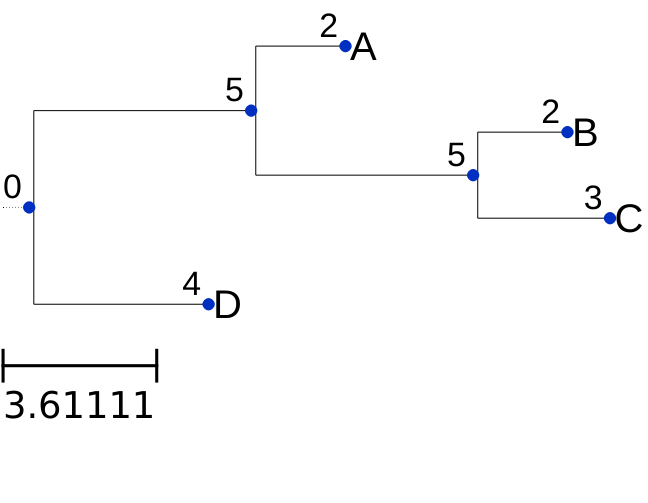

In [18]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 5 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :

![](tree.png)

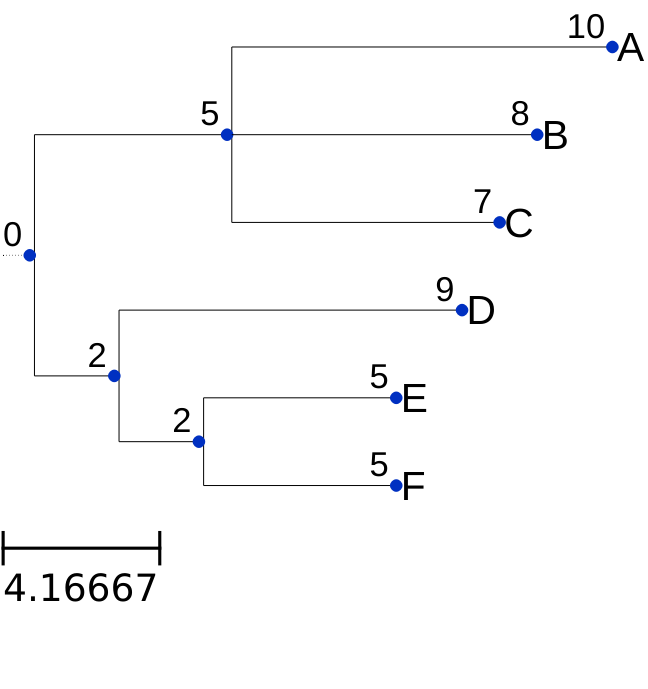

In [19]:
newick_tree = '((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

**Réponse :**
 
Les espèces A, B et C sont homologues, c’est-à-dire qu’elles sont issues d’un même gène ancestral (car elles sont sur la même branche). Elles sont les plus parentés et les plus similaires entre elles. En l'occurrence, ces espèces ont le même caractère dérivé. On peut par exemple faire l'hypothèse que ce type d'embranchement dans un arbre est le résultat d'un isolement géographique, ce qui peut expliquer leur(s) différence(s). Par exemple les Pinsons de Darwin se trouvaient sur des îles différentes et ont dû développer des caractéristiques morphologiques différentes pour survivre, notamment pour se nourrir.

Pinsons de Darwin : https://fr.wikipedia.org/wiki/Pinsons_de_Darwin

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

UPGMA : https://en.wikipedia.org/wiki/UPGMA

In [20]:
matrix = np.array([['0','A','B','C','D','E'],
                   ['A',0,0,0,0,0],
                   ['B',17,0,0,0,0],
                   ['C',21,30,0,0,0],
                   ['D',31,34,28,0,0],
                   ['E',23,21,39,43,0]],dtype='<U50')
matrix

matrix2 = np.array([['0','A','B','C','D'],
                   ['A',0,0,0,0],
                   ['B',4,0,0,0],
                   ['C',8,8,0,0],
                   ['D',2,4,8,0]],dtype='<U50')
matrix2

'0','A','B','C','D'
'A','0','0','0','0'
'B','4','0','0','0'
'C','8','8','0','0'
'D','2','4','8','0'


In [21]:
"""
    @Function : min_matrix
    @Parameters : 
        - [numpy array] matrix : une matrice de distance
    @Return : 
        - [0] : minimum (la valeur minimale dans la matrice)
        - [1] : i_lab (l'indice de la ligne de la valeur minimale)
        - [2] : j_lab (l'indice de la colonne de la valeur minimale)
"""
def min_matrix(matrix):
    size = len(matrix) #taille de la matrice 
    minimum = 10000 #initialisation du minimum à une valeur très grande
    i_lab = 0 #initialisation de l'indice de la ligne de la valeur minimale
    j_lab = 0 #initialisation de l'indice de la colonne de la valeur minimale
    for i in range(size):
        for j in range(size):
            value = matrix[i][j] #récupérer la valeur de la matrice à l'indice i,
            #si elle est inférieur au minimum alors on remplace le minimum par cette valeur et on met à jour i_lab,j_lab
            if value != '0' and value != '' and float(value) < minimum:
                minimum = float(value)
                i_lab = i+1
                j_lab = j+1
    return minimum, i_lab, j_lab

In [22]:
"""
    @Function : UPGMA
    @Parameters : 
        - [numpy array] d_matrix : une matrice de distance
    @Return : 
        - [0] : [numpy array] renvoie la matrice à la dernière éxécution de l'algorithme UPGMA
        - [1] : [char] renvoie l'arbre construit 
"""
def UPGMA(d_matrix):
    M = d_matrix.copy()
    size = len(M)
    visited = np.zeros(len(d_matrix)-1)

  
    while (size > 2):
        """
        On récupère la valeur minimale de la matrice M qu'on va modifier et rétrécir au fur et à mesure
        on a donc le minimum min, l'indice de la ligne x, l'indice de la ligne y et la distance d qui va
        nous servir pour construire l'arbre qui est le minimum/2
        """
        infos = min_matrix(M[1:,1:])
        min = infos[0]
        x = infos[1]
        y = infos[2]
        d = str(min/2)
        
        """
        visité = (A:d,B:d):d par exemple
        non visité = C par exemple
        
        si non visité C et non visité D alors on veut tree = '(C:d,D:d):d'
        si visité (A:d,B:d):d et visité (C:d,D:d):d alors on veut tree = '((A:d,B:d),(C:d,D:d))'
        si visité (A:d,B:d):d et non visité C alors on veut tree = '((A:d,B:d):d,C:d):d'
        si non visité C et visité (A:d,B:d):d alors on veut tree = '(C:d,(A:d,B:d):d):d'
        """
        if visited[x-1] == 0 and visited[y-1] == 0:
            t = '(' + M[y][0] + ':' + d + ',' + M[x][0] + ':' + d + '):' + d
        elif visited[x-1] == 1 and visited[y-1] == 1:
            t = '(' + M[y][0] + ',' + M[x][0] + ')'
        elif visited[x-1] == 1 and visited[y-1] == 0:
            t = '(' + M[x][0] + ',' + M[y][0] + ':' + d + '):' + d
        elif visited[x-1] == 0 and visited[y-1] == 1:
            t = '(' + M[y][0] + ',' + M[x][0] + ':' + d + '):' + d
        
        """
        Avant on avait visited[y-1] et visited[x-1] qui vont fusionner dans visited[y-1] 
        On met donc à jour visited[y-1] à 1 pour dire qu'il a bien été déjà visité et donc fusionnée
        Puis on supprime visited[x-1]
        """
        visited[y-1] = 1
        visited = np.delete(visited, x-1)
        
        """
        Pour l'affichage de la matrice on met à jour les noms en donnant l'arbre actuel
        """
        M[y][0] = t
        M[0][y] = t

        """
        Dans cette fonction on met à jour seulement les valeurs qui ont besoin d'être mise à jour pour 
        ne pas devoir tout recalculer
        """  
        for k in range(1,size):
            if k != x and k != y:
                d1 = (k,y) if k > y else (y,k)
                d2 = (k,x) if k > x else (x,k)    
                new_d = ((float(M[d1])*2) + float(M[d2]))/3
                if (k > y):
                    M[k][y] = new_d
                else:
                    M[y][k] = new_d

        """
        On va supprimer la ligne (x,x) pour garder les bonnes valeurs qu'on ne veut pas supprimer justement
        pour ne pas les recalculer => ce qui revient dans le pire des cas, si elle se trouve au milieu de la
        matrice à la scinder en 4 parties : top_left, top_right, bottom_left et bottom_right.
        """
        top_left = M[np.ix_([i for i in range(0,x)],[i for i in range(0,x)])]
        top_right = M[np.ix_([i for i in range(0,x)],[i for i in range(x+1,size)])]
        bottom_left = M[np.ix_([i for i in range(x+1,size)],[i for i in range(0,x)])]
        bottom_right = M[np.ix_([i for i in range(x+1,size)],[i for i in range(x+1,size)])]

        """
        Puis on recolle les quatres parties sans la ligne et colonne du minimum pour former la nouvelle
        matrice.
        """
        left = np.vstack((top_left,bottom_left))
        right = np.vstack((top_right,bottom_right))
        M = np.hstack((left,right))
        
        """
        On oublie par de mettre à jour la taille 
        """
        size = len(M)
    t = t + ';' 

    return M,t

UPGMA(matrix2)[1]

'(((A:1.0,D:1.0):1.0,B:2.0):2.0,C:4.0):4.0;'

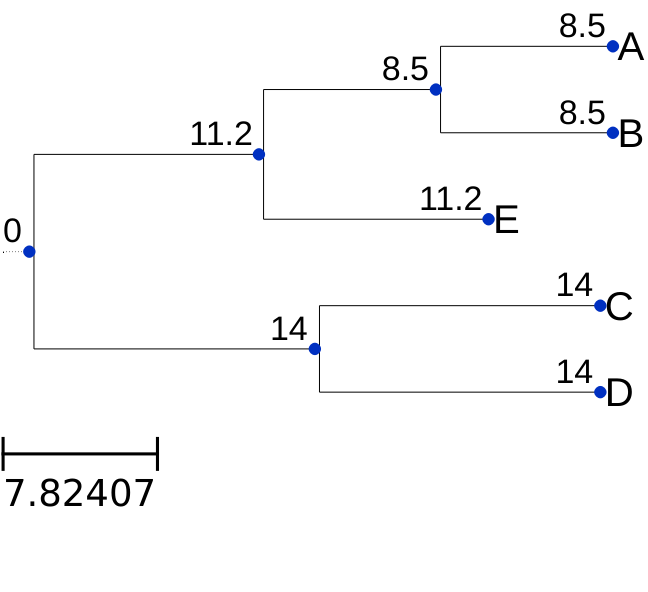

In [23]:
newick_tree = UPGMA(matrix)[1]
t= Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

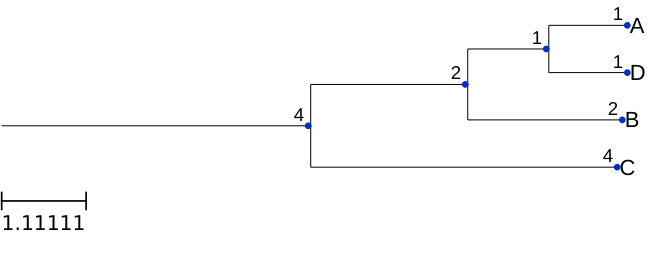

In [24]:
newick_tree = UPGMA(matrix2)[1]
t= Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [25]:
UPGMA(p_distance_matrix)[1]

'((((Sabertooth DNA Smilodon:0.07256057152202995,Homotherium DNA:0.07256057152202995):0.07256057152202995,(Spotted Hyena DNA:0.064717110223176,Striped Hyena DNA:0.064717110223176):0.064717110223176),((((American Cat DNA Miracinonyx:0.02907023934030997,Puma DNA:0.02907023934030997):0.02907023934030997,Cheetah DNA:0.04254348539075701):0.04254348539075701,(((African wild cat DNA:0.0053192381219836545,Wild Cat DNA:0.0053192381219836545):0.0053192381219836545,Felis Cat A DNA:0.008308260720103556):0.008308260720103556,Chinese Desert cat DNA:0.052910891460887365):0.052910891460887365),((Lion DNA:0.03892379763061633,Leopard DNA:0.03892379763061633):0.03892379763061633,Tiger DNA:0.05697238014135884):0.05697238014135884)),((Dog DNA:-0.0,Wolf DNA:-0.0):-0.0,((Brown Bear DNA:0.03503775249228635,Cave Bear DNA:0.03503775249228635):0.03503775249228635,Black Bear DNA:0.060629552559309186):0.060629552559309186));'

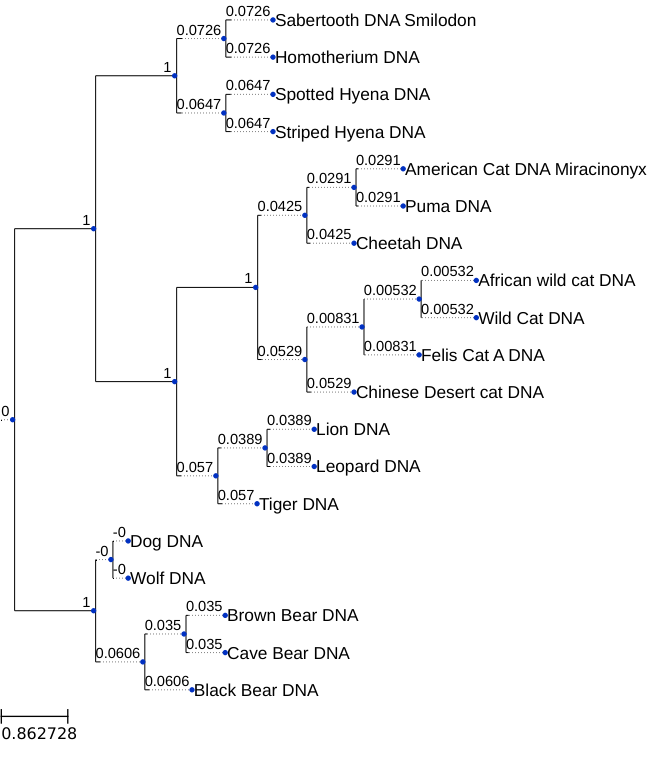

In [26]:
newick_tree = UPGMA(p_distance_matrix)[1]
t= Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Note :**

- Exemple : Les écailles kératinisées que l’on trouve chez les lézards et serpents aujourd’hui ont évolué en poils chez les mammifères ou plumes chez les oiseaux.
On parle alors de caractère ancestral pour l’écaille et de caractère dérivé (ou innovation génétique) pour le poils et la plume. 

- La phylogénie moléculaire repose sur le principe de la comparaison des séquences d’un gène ou de sa protéine partagées par différentes espèces. Si le taux d’homologie entre les séquences est supérieur à 20 % alors on considère qu’elles sont homologues, c’est-à-dire qu’ils sont issues d’un même gène ancestral.

- Le résultat des alignements permet de calculer le taux d’homologie des séquences et d’en déduire le taux de différences ou distance. Ces dernières valeurs sont utilisées pour construire une matrice de distance qui permet d’indiquer la distance qui sépare dans l’arbre chaque séquence. Ainsi, les séquences les plus proches seront les plus proches dans l’arbre. Les séquences les plus éloignées seront les plus lois dans l’arbre.

**Source:**

https://www.maxicours.com/se/cours/principe-de-la-phylogenie-moleculaire/

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

**Réponse :**

UPGMA suppose que la vitesse d'évolution est constante dans toutes les branches de l'arbre (horloge moléculaire (arbre ultramétrique)). Or, si une branche interne évolue beaucoup plus vite que toutes les autres, c'est-à-dire que ces séquences seront très différentes des autres, alors elle se retrouvera à l'extérieur de l'arbre. En l'occurrence ici, l'horloge moléculaire est bien respectée. On peut le voir par rapport à plusieurs points, notamment que chaque noeuds a au moins deux feuilles, les distances sont décroissantes, les distances additives sont respectées etc.


## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

**Réponse :**

L'autre méthode possible pour enraciner un arbre est la méthode d'enracinement avec un groupe extérieur. Dans notre cas, on remarque que le loup, le chien (famille des canidés) et les ours (familles de ursidés) sont un groupe extérieur à la famille des félins. Néanmoins, la branche qui les sépare est déjà à la racine. Il n'y a donc pas besoin d'afficher un nouvel arbre.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

Neighbor-joining : https://en.wikipedia.org/wiki/Neighbor_joining

In [27]:
matrix3 = np.array([['0','A','B','C','D','E'],
                   ['A',0,0,0,0,0],
                   ['B',5,0,0,0,0],
                   ['C',9,10,0,0,0],
                   ['D',9,10,8,0,0],
                   ['E',8,9,7,3,0]],dtype='<U1000000')
matrix3

'0','A','B','C','D','E'
'A','0','0','0','0','0'
'B','5','0','0','0','0'
'C','9','10','0','0','0'
'D','9','10','8','0','0'
'E','8','9','7','3','0'


In [28]:
"""
    @Function : SommeNeighbors
    @Parameters :
        - [numpy array] matrix 
        - [int] index
    @Return : [int] cpt 
"""
def SommeNeighbors(matrix,index):
    #On créer une liste elt qui contient tous les élements dans la matrice sauf l'index 
    elt = np.delete(np.arange(start=1, stop=len(matrix)),index-1)
    cpt = 0 #On initialise un compteur
    #On fait la somme des distances des voisins de intex qu'on retourne ensuite
    for i in elt: 
        if i>index: 
            cpt +=  float(matrix[i][index])
        else:
            cpt += float(matrix[index][i])
    return cpt

SommeNeighbors(matrix3,5)

27.0

In [29]:
"""
    @Function : NeighbordJoining
    @Parameters : [numpy array] d_matrix : matrice de distances 
    @Return : 
        - [1] : [numpy array] nj_matrix : matrice résultat
        - [2] : [numpy array] nj_calcul : matrice de calculs
        - [3] : [tree] t
"""
def NeighbordJoining(d_matrix):
    nj_matrix = d_matrix.copy() #On commence par copier la matrice de distance et c'est sur celle-ci qu'on va itérer pour la rétrécir
    size = len(nj_matrix) #On stocke sa taille qui va donc diminuer
    visited = np.zeros(len(d_matrix)-1) #On stocke un tableau avec les cases de notre matrice qui ont déjà été fusionnées 
    
    while(size > 2):
        nj_calcul = nj_matrix.copy() #On copie la matrice de résultat 
        
        #On fait les calculs nécessaires pour la remplir, on l'occurrence pour chaque case on doit calculer la somme des voisins de i et j 
        for i in range(2,size):
            for j in range(1,i):
                nj_calcul[i][j] = (((size-1)-2)*float(nj_matrix[i][j])) - SommeNeighbors(nj_matrix,j) - SommeNeighbors(nj_matrix,i)

        """
        Une fois la matrice de calcul remplie, on va chercher le minimum dans celle-ci, qui va déterminer les deux espèces x et y 
        à fusionner. Et, on va chercher la distance associée à x et y dans la matrice de résultat pour l'ajouter à la branche.
        """
        infos = min_matrix(nj_calcul[1:,1:]) #On cherche le minimum de la matrice de calcul
        x = infos[1] #On stocke le x de la matrice de calcul
        y = infos[2] #On stocke le y de la matrice de calcul
        d = nj_matrix[x][y] #On stocke la distance comme étant le minimum de la matrice de résultat
        coef = 1/2 if size == 3 else (1/(2*((size-1)-2))) #On gère le cas ou le coefficient sera égal à 0 pour éviter les divisions par 0
        dist1 = str((1/2)*float(nj_matrix[x][y])+coef*(SommeNeighbors(nj_matrix,y) - SommeNeighbors(nj_matrix,x))) #On calcul la distance de x
        dist2 = str(float(nj_matrix[x][y])-float(dist1)) #On calcul la distance de y 

        """
        visité = (A:d,B:d):d par exemple
        non visité = C par exemple
        
        si non visité C et non visité D alors on veut tree = '(C:d,D:d):d'
        si visité (A:d,B:d):d et visité (C:d,D:d):d alors on veut tree = '((A:d,B:d),(C:d,D:d))'
        si visité (A:d,B:d):d et non visité C alors on veut tree = '((A:d,B:d):d,C:d):d'
        si non visité C et visité (A:d,B:d):d alors on veut tree = '(C:d,(A:d,B:d):d):d'
        """
        if visited[x-1] == 0 and visited[y-1] == 0:
            t = '(' + nj_calcul[y][0] + ':' + dist1  + ',' + nj_calcul[x][0] + ':' + dist2 + '):' + d
        elif visited[x-1] == 1 and visited[y-1] == 1:
            t = '(' + nj_calcul[y][0] + ',' + nj_calcul[x][0] + ')'
        elif visited[x-1] == 1 and visited[y-1] == 0:
            t = '(' + nj_calcul[x][0] + ',' + nj_calcul[y][0] + ':' + dist2 + '):' + d
        elif visited[x-1] == 0 and visited[y-1] == 1:
            t = '(' + nj_calcul[y][0] + ',' + nj_calcul[x][0] + ':' + dist1  + '):' + d
        
        """
        Avant on avait visited[y-1] et visited[x-1] qui vont fusionner dans visited[y-1] 
        On met donc à jour visited[y-1] à 1 pour dire qu'il a bien été déjà visité et donc fusionnée
        Puis on supprime visited[x-1]
        """
        visited[y-1] = 1
        visited = np.delete(visited, x-1)
        
        """
        Pour l'affichage de la matrice on met à jour les noms en donnant l'arbre actuel
        """
        nj_matrix[y][0] = t
        nj_matrix[0][y] = t

        """
        Dans cette fonction on met à jour seulement les valeurs qui ont besoin d'être mise à jour pour 
        ne pas devoir tout recalculer
        """  
        for k in range(1,size):
            if k != x and k != y:
                d1 = (k,y) if k > y else (y,k)
                d2 = (k,x) if k > x else (x,k) 
                new_d = (1/2)*(float(nj_matrix[d1]) + float(nj_matrix[d2]) - float(nj_matrix[(x,y)]))
                if (k > y):
                    nj_matrix[k][y] = new_d
                else:
                    nj_matrix[y][k] = new_d

        """
        On va supprimer la ligne (x,x) pour garder les bonnes valeurs qu'on ne veut pas supprimer justement
        pour ne pas les recalculer => ce qui revient dans le pire des cas, si elle se trouve au milieu de la
        matrice à la scinder en 4 parties : top_left, top_right, bottom_left et bottom_right.
        """
        top_left = nj_matrix[np.ix_([i for i in range(0,x)],[i for i in range(0,x)])]
        top_right = nj_matrix[np.ix_([i for i in range(0,x)],[i for i in range(x+1,size)])]
        bottom_left = nj_matrix[np.ix_([i for i in range(x+1,size)],[i for i in range(0,x)])]
        bottom_right = nj_matrix[np.ix_([i for i in range(x+1,size)],[i for i in range(x+1,size)])]


        """
        Puis on recolle les quatres parties sans la ligne et colonne du minimum pour former la nouvelle
        matrice.
        """
        left = np.vstack((top_left,bottom_left))
        right = np.vstack((top_right,bottom_right))
        nj_matrix = np.hstack((left,right))
        
        """
        On oublie par de mettre à jour la taille 
        """
        size = len(nj_matrix)
    t = t + ';' 
    
    return nj_matrix,nj_calcul,t

NeighbordJoining(matrix3)[2]

'((((A:2.0,B:3.0):5,C:3.0):7.0,D:2.0):4.0,E:0.5):1.0;'

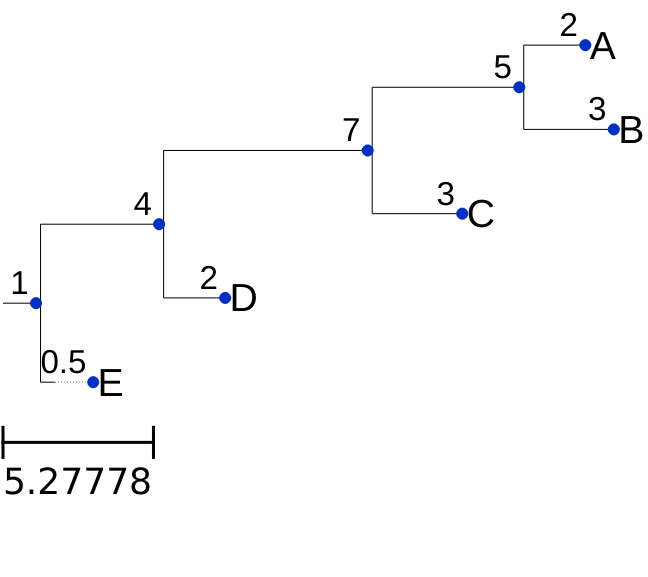

In [30]:
newick_tree = NeighbordJoining(matrix3)[2]
t= Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

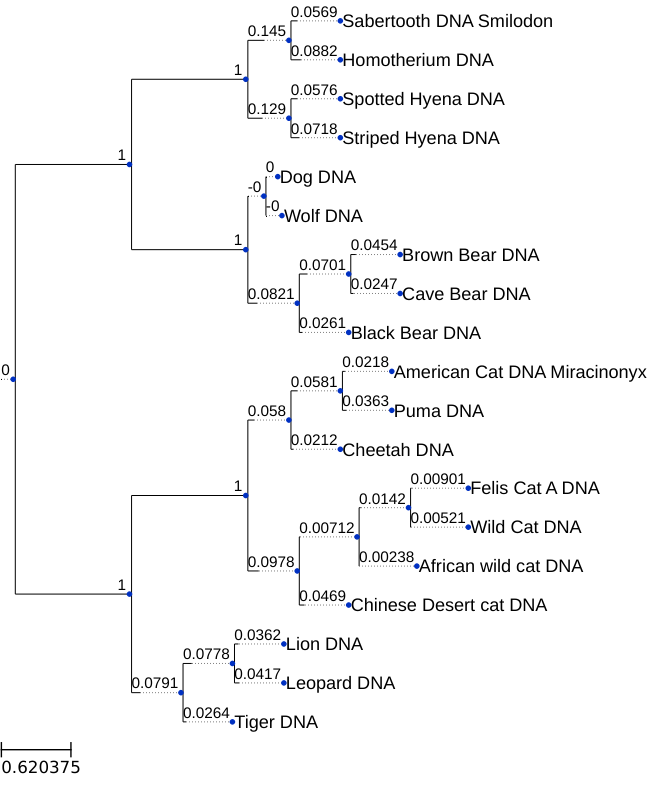

In [31]:
newick_tree = NeighbordJoining(p_distance_matrix)[2]
t= Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 11 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [32]:
import re 

"""
    @Function : generate_couple
    @Parameters : [tree] t
    @Return : [numpy array] arr : matrice résultat
"""
def generate_couple(t):
    arr = np.zeros(0,dtype='<U1000000') #On initialise un tableau qui contiendra des couples de string de noeuds opérationnels de cette forme (a,b) 
    #Fonction récursive 
    def generate_couple_rec(car,arr):
        #Si on rencontre un point virgule c'est qu'on est à la fin d'arbre et donc on peut retourner le tableau
        if t[car] == ';':
            return arr
        else:
            #si on tombe sur une valeur autre qu'un caractère alors on continue à avancer
            if t[car] == '(' or t[car] == ' ' or t[car] == ':' or len(re.findall('[0-9]',t[car])) != 0 or t[car] == '.' or t[car] == '-' or t[car] == ',' or t[car] == ')':
                return generate_couple_rec(car+1,arr)
            else:
                #sinon on prends le nom de l'espece qu'on stocke dans s1
                s1 = re.findall('[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*',t[car:])[0]
                #si avant la distance apres le nom de l'espece on a un - alors on avancera de 3 (pour les : - et , (ici le nom de la deuxieme espece si il y a))
                #sinon on avant que de deux (pour : et ,)
                add = 3 if (t[car+len(s1)+1] == '-') else 2
                #ici on stocke la distance après la s1
                number = re.findall('[0-9][.]*[0-9]*',t[car+len(s1):])[0]
                #ici on stocke le nom de la deuxieme espece après s1 
                s2 = re.findall('[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*',t[car+len(s1)+len(number)+add:])[0]
                #si c'est vide, alors ce n'est pas un couple donc on continuer d'avancer
                if (len(s2) != 0):
                    return generate_couple_rec(car+len(s1)+len(number)+len(s2)+add,np.append(arr,'('+s1+','+s2+')'))
                else:
                    #sinon on ajoute le couple à l'arr 
                    return generate_couple_rec(car+len(s1)+len(number)+2,arr)
    return generate_couple_rec(0,arr)

In [33]:
"""
    @Function : compare_couple
    @Parameters : 
        - [numpy array] arr1 : tableau généré pour l'arbre 1
        - [numpy array] arr2 : tableau généré pour l'arbre 2
    @Return : 1 si une valeur en commun 0 sinon
"""
def compare_couple(arr1,arr2):
    for i in range(0,len(arr1)):
        #pour le couple arr1[i] de la forme (x,y) on cherche x qu'on stocke dans x1 et y qu'on stocke dans y1
        x1 = re.findall('[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*',arr1[i][1:])[0]
        y1 = re.findall('[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*',arr1[i][2+len(x1):])[0]
        for j in range(0,len(arr2)):
            #pour le couple arr2[i] de la forme (x,y) on cherche x qu'on stocke dans x2 et y qu'on stocke dans y2
            x2 = re.findall('[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*',arr2[j][1:])[0]
            y2 = re.findall('[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*[ ]*[a-z-A-Z]*',arr2[j][2+len(x2):])[0]
            """
            Ici, on estime que (x1,y2) = (x1,y2) & (x1,y2) = (y2,x1), on doit donc le prendre en compte
            """
            if ((x1 == x2 or x1 == y2) and (y1 == x2 or y1 == y2)):
                return 1
    return 0

In [34]:
from random import *

"""
    @Function : creer_donnees
    @Parameters : [dictionnaire] seq : fichier fasta converti en dictionnaire
    @Return : [dictionnary] res
"""
def creer_donnees(seq):
    res = {} #Initialisation du dictionnaire qui va stocker un nom d'espèce et une nouvelle séquence
    keyList = list(seq.keys()) #Liste des clés 
    
    #On attribut les clés à notre nouveaux dictionnaires avec des valeurs vides pour le moment
    for i in range(len(seq.keys())):
        res[keyList[i]] = ""

    """   
    Une itération sur seq (à répéter 19 fois en l'occurrence pour le fichier cat_dna):
    - une séquence s1 de taille n du dictionnaire seq
    - la valeur de la séquence res pour la clé associée de taille 0 à remplir
    - un random r = [|0,n|]
     Une itération sur la séquence s1 (à répéter n fois):
        - on choisit le caractère à l'indice r dans s1 (avec remise donc)
        - on l'ajoute à s2
    """
    for j in range(len(list(seq.values())[0])): # jusqu'a 284
        rand = randrange(len(list(seq.values())[0]))
        for i in range(len(seq)): #jusqu'a 19
            res[keyList[i]] += list(seq.values())[i][rand]    
    return res

In [35]:
"""
    @Function : n_new_trees
    @Parameters : 
        - [dictionnaire] seq : dictionnaire de type {nom_espece1:sequence1,...,nom_especeN:sequenceN} alignés
        - [string] name_file : nom du fichier où l'on va écrire nos nouveaux arbres
        - [int] n : nombre d'abres que l'on va créer (dans notre projet 100)
        - [method] method : méthode de création de l'arbre ici "UPGMA" ou "NJ"
    @Return : [list] new_trees
"""
def n_new_trees(seq,name_file,n,method):
    new_trees = [] #list qui va contenir tous les nouveaux arbres
    fichier = open(name_file, 'a') #on commence par ouvrir le fichier en écriture où l'on va stocker nos nouveaux arbres
    
    i = 0 #initialisation du compteur
    
    while i < n:
        nouvelle_sequence = creer_donnees(seq) #On commence par créer notre premier nouveaux dictionnaires avec les séquences mutés (n fois)
        nouveau_arbre = "" #On initialise la chaîne de caractère qui va stocker le nouvel arbre
        if method == "UPGMA":
            try:
                #Si c'est UPGMA alors on créer le nouvel arbre avec cette méthode
                nouveau_arbre = UPGMA(p_distance(nouvelle_sequence,similarity_matrix))[1] 
                i+=1 #On oublie pas d'augmenter le tour de 1
                new_trees.append(nouveau_arbre) #Et on ajoute l'abre à notre liste
            except:
                #Si jamais y a un problème on l'imprime et on recommence
                print(f"Problème à l'itération {i}")
        elif method == "NJ":
            try:
                #Ici même chose mais pour NeighborJoining
                nouveau_arbre = NeighbordJoining(p_distance(nouvelle_sequence,similarity_matrix))[2] 
                i+=1
                new_trees.append(nouveau_arbre)
            except:
                print(f"Problème à l'itération {i}")
        
        #Et finalement, on écrit le nouvel arbre créé dans notre fichier
        fichier.write(nouveau_arbre+"\n")
    fichier.close() #On ferme le fichier 

    return new_trees

In [38]:
#n_new_trees(sequences,'trees_neighbours_joining.txt',100,"NJ")
#n_new_trees(sequences,'new_trees.txt',100,"UPGMA")

In [39]:
"""
    @Function : bootstrap
    @Parameters : 
        - [tree] tree : arbre de référence sur lequel on va se baser
        - [string] name_file : nom du fichier à ouvrir avec tous les autres arbres
    @Return : [int] res : score obtenu à la fin
"""
def bootstrap(tree,name_file):
    filepath = name_file 
    f = open(filepath, "r") #On ouvre en lecture le fichier qui contient tous les arbres qu'on a créé auparavant
    lines = f.readlines() #On va lire les lignes une par une
    
    res = 0 #On initialise le compteur
    for i in range(0,100):
        arr1 = generate_couple(tree) #On commence par générer les couples pour l'arbre de référence
        arr2 = generate_couple(lines[i]) #Puis on génére les couples pour la ligne qu'on est en train de lire
        nb = compare_couple(arr1,arr2) #On compare les deux (renvoie 1 si une branche commune 0 sinon)
        res = res + nb #On ajoute le résultat à res pour obtenir un score sur 100 
        
    return res

In [40]:
bootstrap(UPGMA(p_distance_matrix)[1],"new_trees.txt")

100

In [41]:
bootstrap(NeighbordJoining(p_distance_matrix)[2],"trees_neighbours_joining.txt")

100

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Un peu d'histoire sur l'arbre : 
- https://www.cosmovisions.com/felidesPaleontologie.html
- https://fr.wikibooks.org/wiki/Wikijunior:Les_f%C3%A9lins/Historique_(les_fossiles)

**Réponse :**

RQ : Ce n'est pas étonnant d'obtenir des valeurs de bootstrap de 100 car le couple chien-loup se ressemble beaucoup et par conséquent on le retrouvera à chaque fois.

Question 1) 

- Smilodon et Homotherium ont des caractèristiques morphologiques similaires car ils sont homologues et ont un ancêtre commun avec les chats en remontant l'arbre

[+] le Smilodon et Homotherium sont tout deux disparus et ont pour point communs d'avoir des dents de sabres 

- M.trumani a des caractéristiques morphologiques similaires avec Smilodon et Homotherium car il est très proche des chats qui ont un ancêtre commun avec celles-ci


Question 2)

- Algorithmiquement parlant, comme UPGMA ne prend pas en compte le taux d'évolution elle est plus rapide que Neighbor Joining mais elle reste moins fiable

- Sinon, si on regarde l'arbre phylogénétique on observe que UPGMA produit un arbre enraciné tandis que Neighbor Joining produit un arbre phylogénétique non enraciné 
